# Resume Scoring Model Development Notebook (Updated for New Dataset)

**Dataset Structure:**
- Resume_ID: Unique ID
- Name: Candidate name
- Skills: Skills list
- Experience (Years): Years of experience
- Education: Education level
- Certifications: Certifications (some missing)
- Job Role: Target job role
- Recruiter Decision: Hiring decision
- Salary Expectation ($): Expected salary
- Projects Count: Number of projects
- AI Score (0-100): Target variable

In [ ]:
%pip install pandas
%pip install xgboost
%pip install lightgbm

import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, OneHotEncoder # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore
from sklearn.svm import SVR # type: ignore
from xgboost import XGBRegressor # type: ignore
from lightgbm import LGBMRegressor # type: ignore
import nltk # type: ignore
from nltk.corpus import stopwords # type: ignore
import re # type: ignore
import joblib # type: ignore

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Load dataset
df = pd.read_csv('./AI_Resume_Screening.csv')

# EDA

In [3]:
# Configuration
nltk.download('stopwords')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Basic info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nColumns and Non-Null Counts:")
print(df.info())
print("\nSample Data:")
df.head(3)

Dataset Info:
Shape: (1000, 11)

Columns and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score (0-100)        1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None

Sample Data:


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70


In [5]:
# Missing values analysis
print("\nMissing Values Analysis:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing Values Analysis:
Certifications    274
dtype: int64


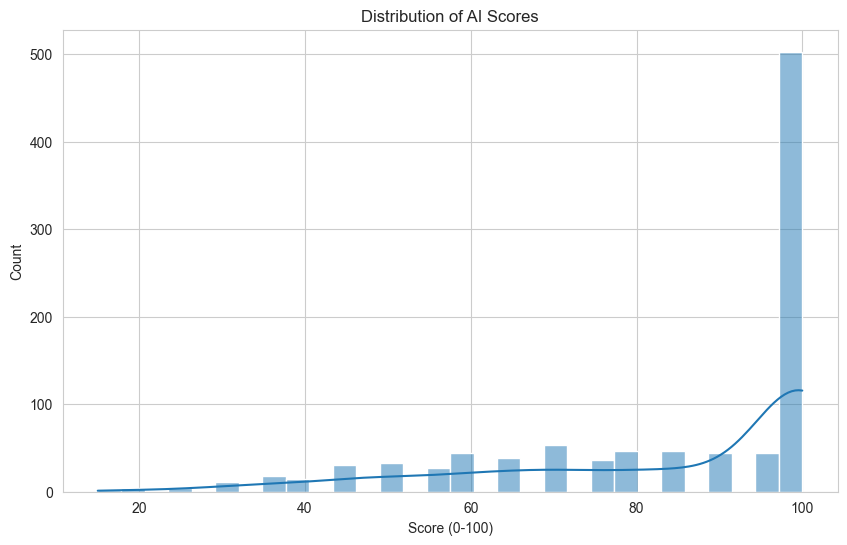

In [6]:
# Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['AI Score (0-100)'], bins=30, kde=True)
plt.title('Distribution of AI Scores')
plt.xlabel('Score (0-100)')
plt.ylabel('Count')
plt.show()

In [7]:
# Numerical features analysis
num_cols = ['Experience (Years)', 'Salary Expectation ($)', 'Projects Count']
df[num_cols].describe()

,Experience (Years),Salary Expectation ($),Projects Count
count,1000.000000,1000.000000,1000.00000
mean,4.896000,79994.486000,5.13300
std,3.112695,23048.472549,3.23137
min,0.000000,40085.000000,0.00000
25%,2.000000,60415.750000,2.00000
50%,5.000000,79834.500000,5.00000
75%,8.000000,99583.250000,8.00000
max,10.000000,119901.000000,10.00000



Education Value Counts:
Education
B.Sc      205
MBA       202
B.Tech    200
M.Tech    198
PhD       195
Name: count, dtype: int64


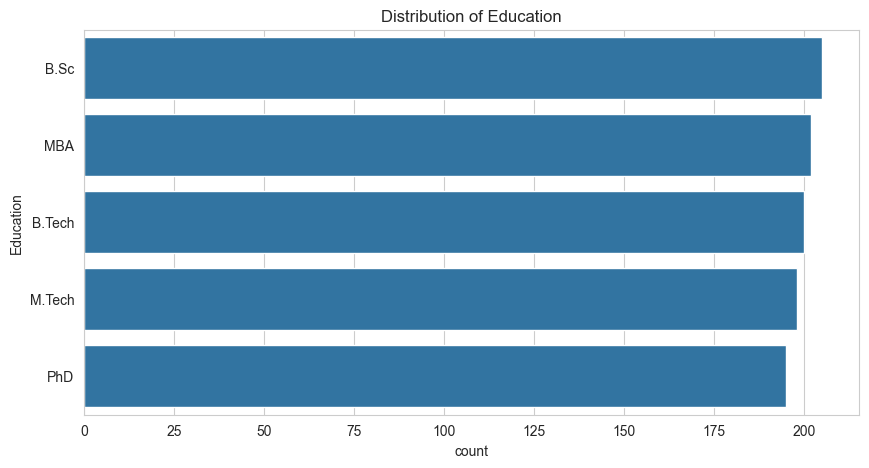


Job Role Value Counts:
Job Role
AI Researcher            257
Data Scientist           255
Cybersecurity Analyst    255
Software Engineer        233
Name: count, dtype: int64


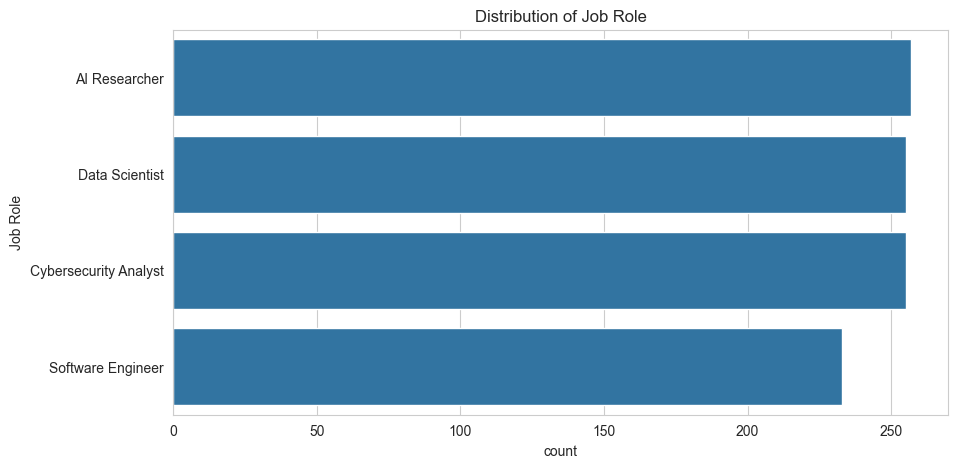


Recruiter Decision Value Counts:
Recruiter Decision
Hire      812
Reject    188
Name: count, dtype: int64


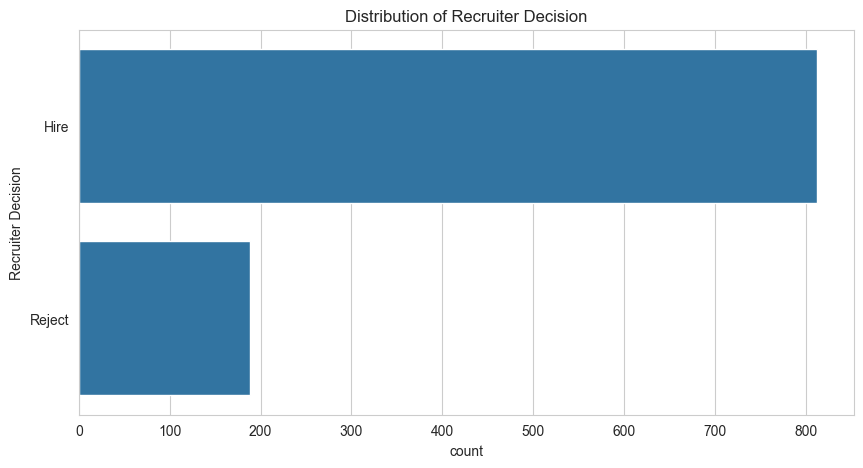

In [8]:
# Categorical features analysis
cat_cols = ['Education', 'Job Role', 'Recruiter Decision']

for col in cat_cols:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts())
    
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

In [9]:
# Skills analysis (example of processing list-like data)
df['Skills_Count'] = df['Skills'].apply(lambda x: len(x.split(',')))
print("\nSkills Count Statistics:")
print(df['Skills_Count'].describe())


Skills Count Statistics:
count    1000.000000
mean        3.017000
std         0.805829
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Skills_Count, dtype: float64


# Preprocesing

In [10]:
def enhanced_text_cleaning(text):
    """Advanced text cleaning pipeline"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s.,;!?]', '', text)
    text = re.sub(r'\b(b\.?sc|bachelor|bs)\b', 'bachelor', text)
    text = re.sub(r'\b(m\.?sc|master|ms)\b', 'master', text)
    text = re.sub(r'\b(ph\.?d|doctorate)\b', 'phd', text)
    
    return text.strip()

def create_features(df):
    """Create advanced features"""
    # Text cleaning
    text_cols = ['Skills', 'Education', 'Certifications', 'Job Role']
    for col in text_cols:
        df[col] = df[col].apply(enhanced_text_cleaning)
    
    # Handle missing values
    df['Certifications'] = df['Certifications'].fillna('none')
    
    # Create count features
    df['Skills_Count'] = df['Skills'].apply(lambda x: len(x.split(',')))
    df['Certs_Count'] = df['Certifications'].apply(lambda x: 0 if x == 'none' else len(x.split(',')))
    
    # Create interaction features
    df['Exp_Skill_Interaction'] = df['Experience (Years)'] * df['Skills_Count']
    df['Salary_Project_Ratio'] = df['Salary Expectation ($)'] / (df['Projects Count'] + 1)
    
    # Create binary features
    df['Has_PhD'] = df['Education'].str.contains('phd|doctorate').astype(int)
    
    return df

# Apply preprocessing
processed_df = create_features(df.copy())

In [11]:
# Define features and target
numerical_features = [
    'Experience (Years)', 
    'Salary Expectation ($)',
    'Projects Count',
    'Skills_Count',
    'Certs_Count',
    'Exp_Skill_Interaction',
    'Salary_Project_Ratio',
    'Has_PhD'
]

categorical_features = ['Job Role']
text_features = 'Combined_Text'
target = 'AI Score (0-100)'

In [12]:
# Create combined text feature
processed_df['Combined_Text'] = (
    processed_df['Education'] + " " + 
    processed_df['Skills'] + " " + 
    processed_df['Certifications']
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    processed_df[numerical_features + categorical_features + [text_features]],
    processed_df[target],
    test_size=0.2,
    random_state=42
)

In [13]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        max_features=1000,
        stop_words=stopwords.words('english'),
        ngram_range=(1, 2)
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features)
    ])

# Pemodelan

In [ ]:
from sklearn.ensemble import RandomForestRegressor # type: ignore

model_dict = {
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

In [15]:
# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'model': type(model).__name__,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'pipeline': pipeline
    }

# Evaluate all models
results = []
for name, model in model_dict.items():
    print(f"\nEvaluating {name}...")
    result = evaluate_model(model, X_train, X_test, y_train, y_test)
    result['name'] = name  # simpan nama friendly-nya
    result['model_obj'] = model  # simpan object model-nya
    results.append(result)
    print(f"{name} - MAE: {result['mae']:.2f}, R2: {result['r2']:.4f}")


# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['name', 'mae', 'r2']])

# Ambil best model
best_result = results_df.loc[results_df['r2'].idxmax()]
best_model_name = best_result['name']
best_model_obj = best_result['model_obj']
print(f"\nBest model: {best_model_name}")


Evaluating XGBRegressor...
XGBRegressor - MAE: 2.06, R2: 0.9808

Evaluating LGBMRegressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3234
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 103
[LightGBM] [Info] Start training from score 84.325000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\ASUS\Downloads\MBKM DataIns\RAG CV\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RandomForestRegressor - MAE: 2.34, R2: 0.9754

Model Comparison:
                    name       mae        r2
0           XGBRegressor  2.058678  0.980776
1          LGBMRegressor  1.721427  0.988564
2  RandomForestRegressor  2.337500  0.975403

Best model: LGBMRegressor


In [16]:
# Hyperparameter tuning for best model
best_model_name = results_df.loc[results_df['r2'].idxmax(), 'model']
print(f"\nBest model: {best_model_name}")

# Definisikan parameter grid yang lebih lengkap
if best_model_name == 'XGBRegressor':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
elif best_model_name == 'LGBMRegressor':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__num_leaves': [31, 63, 127],
        'model__max_depth': [-1, 5, 10],
        'model__feature_fraction': [0.8, 1.0]
    }
else:  # RandomForest or similar tree-based models
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__bootstrap': [True, False]
    }

# Ambil instance model yang sesuai dari pipeline sebelumnya
best_model_obj = model_dict[best_model_name]

# Buat ulang pipeline dengan model terbaik
tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model_obj)
])

# Lakukan GridSearchCV
grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("\nPerforming hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Tampilkan hasil tuning terbaik
print("\nBest parameters found:")
print(grid_search.best_params_)



Best model: LGBMRegressor

Performing hyperparameter tuning...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3234
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 103
[LightGBM] [Info] Start training from score 84.325000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [17]:
# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTuned Model Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0

Tuned Model Performance:
MAE: 1.69
R2: 0.9891


c:\Users\ASUS\Downloads\MBKM DataIns\RAG CV\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


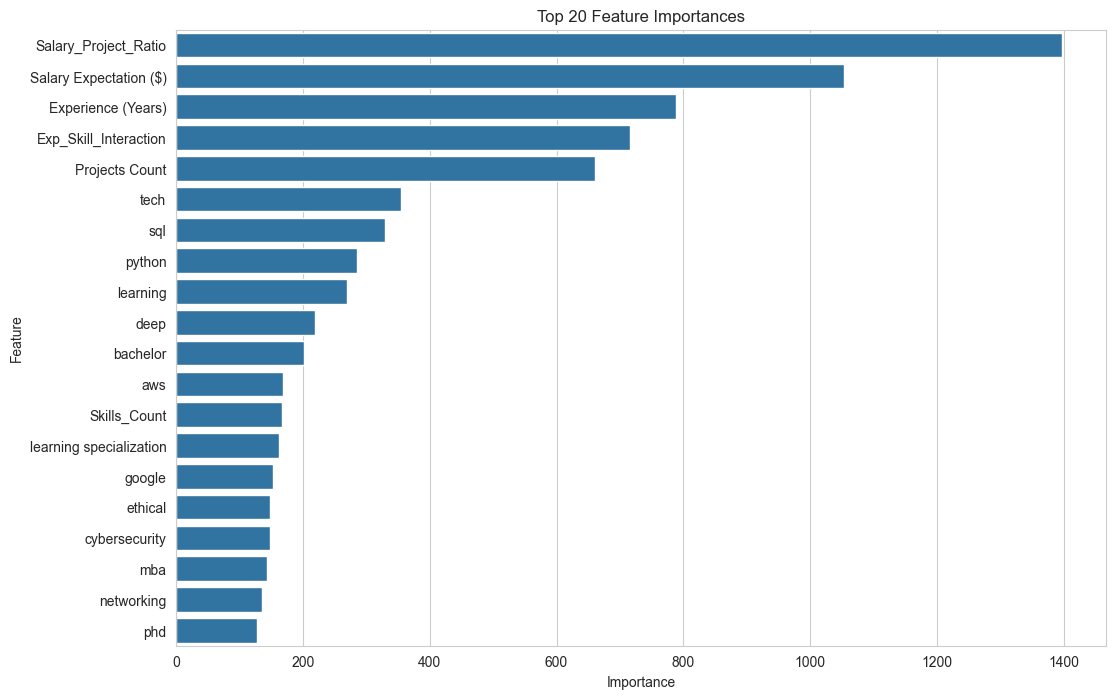

In [18]:
# Plot feature importance for tree-based models
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    numeric_features = numerical_features
    cat_features = best_model.named_steps['preprocessor']\
        .named_transformers_['cat']\
        .named_steps['onehot']\
        .get_feature_names_out(categorical_features)
    text_features = best_model.named_steps['preprocessor']\
        .named_transformers_['text']\
        .named_steps['tfidf']\
        .get_feature_names_out()
    
    all_features = np.concatenate([numeric_features, cat_features, text_features])
    
    importances = best_model.named_steps['model'].feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Top 20 Feature Importances')
    plt.show()

# Save Model

c:\Users\ASUS\Downloads\MBKM DataIns\RAG CV\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0

Contoh 15 Prediksi vs Aktual:
    Index   Predicted  Actual
0     521   99.633978     100
1     737  100.697510     100
2     740  100.556709     100
3     660  100.743444     100
4     411   51.494510      50
5     678   99.941285     100
6     626   45.186247      45
7     513   45.115619      50
8     859  101.265788     100
9     136   87.532557      80
10    811   42.599245      45
11     76   25.592572      20
12    636   99.942419     100
13    973   86.133774      90
14    938   60.381575      60


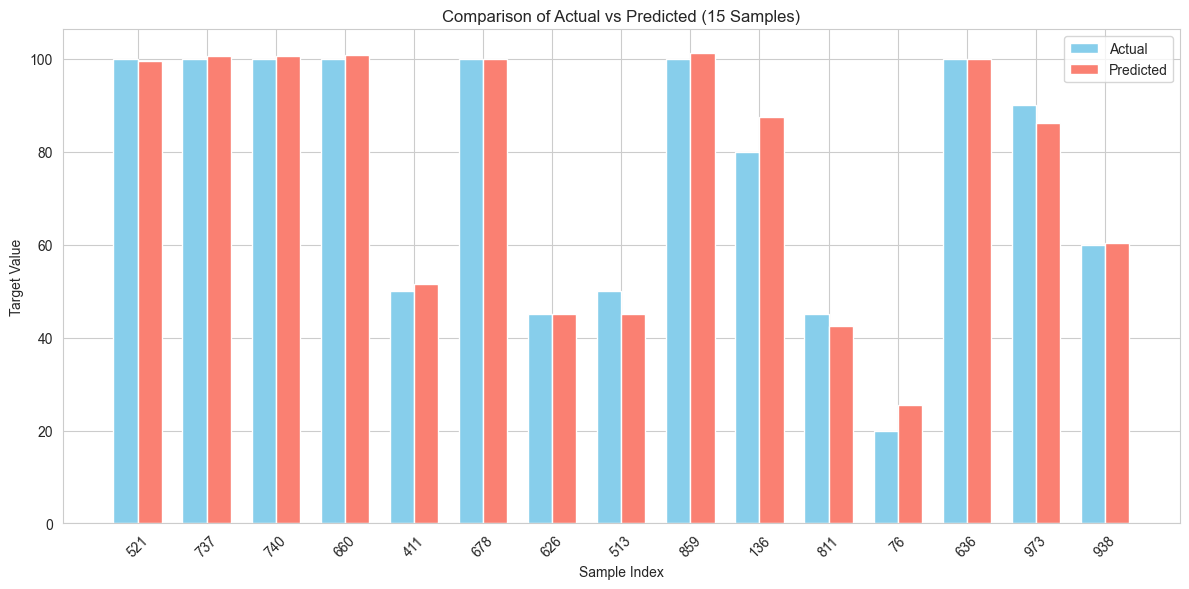

In [19]:
# Save the best model
joblib.dump(best_model, './best_resume_scorer.pkl')

# Example prediction
# Ambil 15 contoh dari X_test
sample_resumes = X_test.iloc[:15]
predictions = best_model.predict(sample_resumes)
actuals = y_test.iloc[:15].values

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Index': sample_resumes.index,
    'Predicted': predictions,
    'Actual': actuals
})

# Tampilkan hasil prediksi vs aktual
print("\nContoh 15 Prediksi vs Aktual:")
print(comparison_df)

# Visualisasi bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.35
indices = np.arange(len(comparison_df))

plt.bar(indices, comparison_df['Actual'], bar_width, label='Actual', color='skyblue')
plt.bar(indices + bar_width, comparison_df['Predicted'], bar_width, label='Predicted', color='salmon')

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Comparison of Actual vs Predicted (15 Samples)')
plt.xticks(indices + bar_width / 2, comparison_df['Index'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()